In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
from rl_analysis.util import count_transitions
from rl_analysis.io.df import dlight_exclude
from sklearn import model_selection

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
dlight_cfg = analysis_config["dlight_common"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
encoding_cfg = analysis_config["dlight_encoding_features"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(
    raw_dirs["dlight"], f"dlight-chrimson_snippets_{file_suffix}.parquet"
)

In [ ]:
from scipy.stats import pearsonr


def _pearsonr(x, y):
    nans = np.isnan(x) | np.isnan(y)
    return pearsonr(x[~nans], y[~nans])


def _zscore(x, axis=1):
    with np.errstate(divide="ignore", invalid="ignore"):
        return (x - np.nanmean(x, axis=axis, keepdims=True)) / np.nanstd(
            x, axis=axis, keepdims=True
        )


def compare_tms(
    predicted_tm,
    true_tm,
    normalization_func=lambda x: _zscore(x, axis=1),
    compare_func=lambda x, y: _pearsonr(x, y)[0],
    ignore_diagonal=True,
):
    tm1 = predicted_tm.copy()
    tm2 = true_tm.copy()
    tm2 = tm2[: tm1.shape[0], : tm1.shape[1]]

    if ignore_diagonal:
        np.fill_diagonal(tm1, np.nan)
        np.fill_diagonal(tm2, np.nan)

    if normalization_func is not None:
        tm1 = normalization_func(tm1)
        tm2 = normalization_func(tm2)

    # any off-diagonal nans?  if so bail
    isnan1 = np.isnan(tm1)
    isnan2 = np.isnan(tm2)

    try:
        return compare_func(tm1.ravel(), tm2.ravel())
    except Exception as e:
        print(e)
        return np.nan

## Pre-process data

In [7]:
use_data = pd.read_parquet(
    os.path.join(raw_dirs["rl_modeling"], "rl_modeling_dlight_data_offline.parquet")
)
use_data = dlight_exclude(
    use_data, exclude_3s=False, exclude_target=False, **dlight_cfg
)
use_data = use_data[~use_data["session_number"].isin([1, 2, 3, 4])].copy()
use_data = use_data.loc[use_data["area"] == "dls"].copy()
use_data = use_data.dropna(subset=["signal_reref_dff_z_max"])

In [8]:
syllable_key = "syllable"
feature_key = "signal_reref_dff_z_max"
reference_key = "reference_dff_z_max"

In [11]:
cutoff_uuid = 2500
cutoff_date = cutoff_uuid
test_size = 0.5
truncate = 10

In [12]:
group_obj = use_data.groupby(["mouse_id", "uuid"])
use_data = group_obj.filter(lambda x: len(x) >= cutoff_uuid)
group_obj = use_data.groupby(["mouse_id", "uuid"])

In [14]:
# gather data, split off training data for optimizing hyperparameters
seqs = np.array([df[syllable_key].values[:cutoff_date] for k, df in group_obj])
features = np.array([df[feature_key].values[:cutoff_date] for k, df in group_obj])
timestamps = np.array([df["timestamp"].values[:cutoff_date] for k, df in group_obj])
keys = [k for k, _ in group_obj]

In [15]:
nsyllables = use_data["syllable"].max()

In [16]:
base_q_table = np.ones((nsyllables, nsyllables))
np.fill_diagonal(base_q_table, 0)

In [17]:
ref_tms = [count_transitions(_, K=57).astype("float") for _ in seqs]
[np.fill_diagonal(_, np.nan) for _ in ref_tms]
ref_tms = np.array(ref_tms)[:, :truncate, :truncate]

In [18]:
ref_tms_clip = [count_transitions(_[:], K=57).astype("float") for _ in seqs]
[np.fill_diagonal(_, np.nan) for _ in ref_tms_clip]
ref_tms_clip = np.array(ref_tms)[:, :truncate, :truncate]

In [19]:
splits = model_selection.KFold(n_splits=2, shuffle=False)
splits = list(splits.split(range(len(seqs))))
n_splits = len(splits)

### Split into train/test by session

In [20]:
save_file_basename = "rl_model_heldout_results"
base_dir = os.path.join(proc_dirs["rl_modeling"])
save_file = os.path.join(base_dir, f"{save_file_basename}_lags.parquet")

In [21]:
# time_losses = defaultdict(list)
time_df = pd.read_parquet(save_file)
tm_dct = joblib.load(save_file.replace("parquet", "p"))
for k, v in tm_dct.items():
    time_df[k] = v

In [22]:
group_keys = ["lag", "fold", "batch", "model"]

In [23]:
ave_time_df = time_df.groupby(group_keys).mean()
ave_time_df["q_table"] = time_df.groupby(group_keys)["q_table"].mean()
ave_time_df["ref_tm"] = time_df.groupby(group_keys)["ref_tm"].mean()
ave_time_df["ave_r_tm"] = ave_time_df.apply(
    lambda x: compare_tms(x["ref_tm"], x["q_table"]), axis=1
)

/tmp/ipykernel_1431536/612907928.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_time_df = time_df.groupby(group_keys).mean()


In [24]:
save_file = os.path.join(base_dir, f"{save_file_basename}_best_lag_rands.parquet")

In [25]:
rand_df = pd.read_parquet(save_file)
tm_dct = joblib.load(save_file.replace("parquet", "p"))
for k, v in tm_dct.items():
    rand_df[k] = v

In [26]:
group_keys = ["lag", "fold", "batch"]

In [27]:
ave_rand_df = rand_df.groupby(group_keys).mean()
ave_rand_df["q_table"] = rand_df.groupby(group_keys)["q_table"].mean()
ave_rand_df["ref_tm"] = rand_df.groupby(group_keys)["ref_tm"].mean()
ave_rand_df["ave_r_tm"] = ave_rand_df.apply(
    lambda x: compare_tms(x["q_table"], x["ref_tm"]), axis=1
)

/tmp/ipykernel_1431536/1316167550.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_rand_df = rand_df.groupby(group_keys).mean()


In [28]:
best_lag = (
    ave_time_df.groupby(["model", "lag"])["ave_r_tm"]
    .mean()
    .groupby("model")
    .idxmax()
    .apply(lambda x: x[-1])
)
# best_lag = 0

In [29]:
plt_time_df = (
    ave_time_df.groupby("model")
    .apply(lambda x: x.loc[best_lag.loc[x.name]])
    .groupby(["model", "batch"])
    .mean()
)

/tmp/ipykernel_1431536/403092957.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [30]:
plt_rand_df = ave_rand_df.loc[best_lag.loc["dynamic"]].groupby(["batch"]).mean()

/tmp/ipykernel_1431536/3467843857.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt_rand_df = ave_rand_df.loc[best_lag.loc["dynamic"]].groupby(["batch"]).mean()


In [31]:
bins = np.linspace(-0.25, 0.5, 30)

In [32]:
hist_kwargs = {
    "element": "step",
    "fill": True,
    "bins": bins,
    "ec": "k",
    "lw": None,
    "stat": "percent",
}

In [33]:
setup_plotting_env()

/tmp/ipykernel_1431536/3185391148.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=ave_time_df.groupby(["lag", "model", "batch"]).mean().reset_index(),


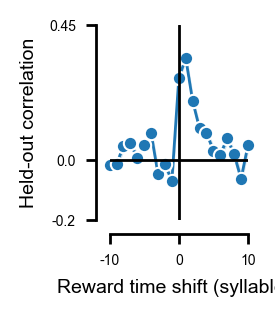

In [34]:
g = sns.relplot(
    data=ave_time_df.groupby(["lag", "model", "batch"]).mean().reset_index(),
    x="lag",
    y="ave_r_tm",
    kind="line",
    marker="o",
    hue="model",
    hue_order=["dynamic"],
    legend=False,
    clip_on=False,
)
g.fig.set_size_inches(1.25, 1.5)
g.refline(y=0, color=plt.rcParams["axes.edgecolor"], ls="-")
g.refline(x=0, color=plt.rcParams["axes.edgecolor"], ls="-")
sns.despine(offset=5)
plt.xlim(-10, 10)
plt.ylim(-0.2, 0.45)
clean_ticks(g.axes.flat[0], "x", dtype=int, precision=0)
clean_ticks(g.axes.flat[0], "y", precision=2, zero_symmetry=False)
g.set_axis_labels("Reward time shift (syllables)", "Held-out correlation")
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "rl_model_v3_dynamic_lags"),
    bbox_inches="tight",
)

In [35]:
plt_time_df.groupby("model")["ave_r_tm"].mean()

model
dynamic    0.340368
static     0.163235
Name: ave_r_tm, dtype: float64

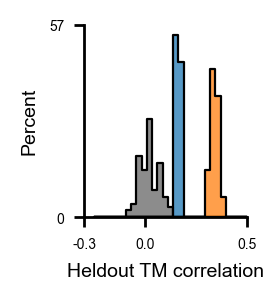

In [36]:
fig, ax = plt.subplots(1, figsize=(1.05, 1.25))
sns.histplot(plt_rand_df["ave_r_tm"], color=[0.4, 0.4, 0.4], **hist_kwargs)
sns.histplot(
    plt_time_df.loc["static"]["ave_r_tm"],
    color=sns.color_palette()[0],
    **hist_kwargs,
)
sns.histplot(
    plt_time_df.loc["dynamic"]["ave_r_tm"],
    color=sns.color_palette()[1],
    **hist_kwargs,
)

sns.despine(offset=0)
plt.xlim(-0.3, 0.45)
clean_ticks(ax, "y", precision=0, dtype=int)
clean_ticks(ax, "x", precision=1, zero_symmetry=False)
ax.set_xlabel("Heldout TM correlation")
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "rl_model_v3_dynamic_v_static_corrs"),
    bbox_inches="tight",
)

In [37]:
model_pval = (
    plt_time_df.groupby("model")["ave_r_tm"]
    .apply(lambda x: (x <= plt_rand_df["ave_r_tm"].quantile(1)).mean())
    .rename("pval")
)
model_r = plt_time_df.groupby("model")["ave_r_tm"].mean().rename("correlation")
model_n = plt_time_df.groupby("model").size().rename("n")

In [38]:
stats_df = pd.concat([model_pval, model_r, model_n], axis=1)

In [39]:
exp_dict = stats_df.to_dict()

In [40]:
exp_dict["n"]["rand"] = len(plt_rand_df)

In [41]:
exp_dict["test_definition"] = "comparison to shuffle"

In [42]:
model_pval

model
dynamic    0.0
static     0.0
Name: pval, dtype: float64

In [43]:
with open(os.path.join(proc_dirs["rl_modeling"], "rl_model_stats.toml"), "w") as f:
    toml.dump(exp_dict, f)

In [44]:
np.mean(plt_time_df.loc["static"]["ave_r_tm"] <= plt_rand_df["ave_r_tm"].quantile(0.99))

0.0

# Viz TM Examples

In [45]:
tms = time_df.set_index(["lag", "fold", "repeat", "batch", "model"])

In [46]:
tms = tms.groupby("model").apply(lambda x: x.loc[best_lag.loc[x.name]])

In [47]:
raw_corr = tms.apply(lambda x: compare_tms(x["ref_tm"], x["q_table_raw"]), axis=1)
raw_corr.index = raw_corr.index.droplevel(-1)

In [51]:
idx = (1, 16, 16)

In [52]:
suffix = "_".join([f"{_}-{_idx}" for _, _idx in zip(tms.index.names[1:], idx)])

In [53]:
observed_tm = np.nanmean(ref_tms_clip[splits[idx[0]][1]], axis=0)

/tmp/ipykernel_1431536/3320039011.py:1: RuntimeWarning: Mean of empty slice
  observed_tm = np.nanmean(ref_tms_clip[splits[idx[0]][1]], axis=0)


In [54]:
# norm_func = _zscore
norm_func = lambda x: x / np.nansum(x, axis=1, keepdims=True)

In [55]:
dynamic_tm = norm_func(tms.loc["dynamic"].loc[idx]["q_table_raw"].iat[0])
baseline_tm = norm_func(tms.loc["static"].loc[idx]["q_table_raw"].iat[0])
init_tm = np.ones((truncate, truncate))

In [56]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [57]:
cluster_mat = np.nan_to_num(_zscore(observed_tm))
cluster_mat = pdist(cluster_mat.T)

In [58]:
dn = dendrogram(
    linkage(
        cluster_mat,
        method="complete",
        optimal_ordering=True,
    ),
    no_plot=True,
)

In [59]:
_order = dn["leaves"]

In [60]:
def softmax(x):
    xbar = np.exp(x)
    return xbar / np.nansum(xbar, axis=1, keepdims=True)

In [61]:
model_tms = {}

In [62]:
use_temperature = 0.1

In [63]:
for _type in ["dynamic", "static"]:
    _tmp = tms.loc[_type].loc[idx]["q_table_raw"].iat[0]
    nans = np.isnan(_tmp)
    _tmp = (_tmp - np.nanmax(_tmp, axis=1, keepdims=True)) / use_temperature
    _tmp = softmax(_tmp)
    _tmp[nans] = np.nan
    model_tms[_type] = _tmp

In [64]:
model_tms["observed"] = norm_func(observed_tm)

In [65]:
for k, v in model_tms.items():
    _tmp = v[_order]
    _tmp = _tmp[:, _order]
    model_tms[k] = _tmp

In [66]:
use_cmap = plt.matplotlib.cm.magma.copy()
use_cmap.set_bad([0, 0, 0, 1])

In [67]:
kwargs = {"vmin": 0, "vmax": 0.4, "cmap": use_cmap}

In [68]:
suffix = "_".join([f"{_}-{_idx}" for _, _idx in zip(tms.index.names[1:], idx)])

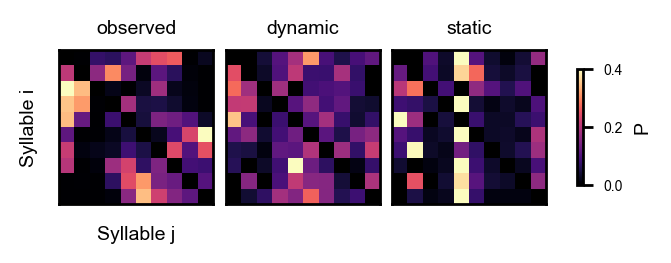

In [69]:
fig, ax = plt.subplots(1, len(model_tms), figsize=(4, 1), sharex=True, sharey=True)
for _type, _ax in zip(["observed", "dynamic", "static"], ax):
    h = _ax.imshow(model_tms[_type], **kwargs)
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.set_title(_type)
ax[0].set_ylabel("Syllable i")
ax[0].set_xlabel("Syllable j")
plt.subplots_adjust(hspace=0.15, wspace=0.025)
plt.colorbar(h, ax=ax.ravel(), shrink=0.75, label="P", ticks=[0, 0.2, 0.4])
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"rl_model_v3_tm_{suffix}_softmax-temp-{use_temperature}",
    ),
    bbox_inches="tight",
)

In [72]:
import cmocean

In [73]:
use_cmap = cmocean.cm.ice.copy()
use_cmap.set_bad("k")

In [74]:
kwargs = {"vmin": 0, "vmax": 0.1, "cmap": use_cmap}

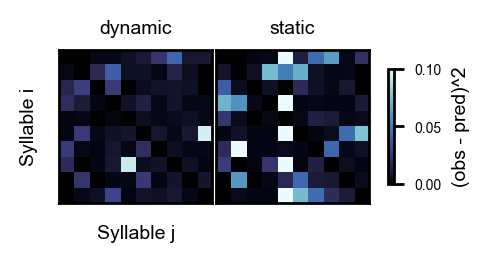

In [75]:
fig, ax = plt.subplots(
    1, len(model_tms) - 1, figsize=(2.5, 1), sharex=True, sharey=True
)
for _type, _ax in zip(["dynamic", "static"], ax):
    h = _ax.imshow((model_tms[_type] - model_tms["observed"]) ** 2, **kwargs)
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.set_title(_type)
ax[0].set_ylabel("Syllable i")
ax[0].set_xlabel("Syllable j")
plt.subplots_adjust(hspace=0.15, wspace=0.025)
plt.colorbar(
    h, ax=ax.ravel(), shrink=0.75, label="(obs - pred)^2", ticks=[0, 0.05, 0.1]
)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"rl_model_v3_squareddiff_{suffix}_softmax-temp-{use_temperature}",
    ),
    bbox_inches="tight",
)